<font size="5"> This notebook will run the static simulation to obtain the residual stress in the triangular network. </font>

In [1]:
import springlattice as sl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import erf

Below we define some of the functions choices for different axsymmetic inelastic strain distributions:

- radial power law $\epsilon^*(r) = \epsilon^0\ \left(\frac{r}{R}\right)^m \text{for}\;\; r/R \leq 1$

- radial decreasing power law $\epsilon^*(r) = \epsilon^0 \left \{1 - \left[ 1 - \frac{r}{R}\right]^m \right\} \text{for}\;\; r/R \leq 1$

- radial increasing gaussian $\epsilon^*(r) = \epsilon^0 \exp\left\{-a \left(1-\frac{r}{R}\right)^2\right\} \text{for}\;\; r/R \leq 1$

- constant inelastic strain $\epsilon^*(r) = \epsilon^0$

- rectangular power law $\epsilon^*(r) = \epsilon^0\ \left(\frac{r}{R}\right)^m \text{for}\;\; r/R \leq 1$



In [2]:
def radial_powerlaw(x, y, m , R, ec=0.025):
    xc = np.mean(x)/R; yc = np.mean(y)/R
    r = np.sqrt((x/R - xc)**2 + (y/R - yc)**2)
    
    exx = np.zeros_like(r); eyy = np.zeros_like(r); exy = np.zeros_like(r)

    # increasing strain
    mask = r <= 1
    exx[mask] = ec * r[mask]**m
    eyy[mask] = ec * r[mask]**m

    # remaining zero strain
    mask = r > 1
    exx[mask] = ec
    eyy[mask] = ec

    return exx, eyy, exy

def radial_decreasing_powerlaw(x, y, m , R, ec=0.025):
    xc = np.mean(x)/R; yc = np.mean(y)/R
    r = np.sqrt((x/R - xc)**2 + (y/R - yc)**2)
    
    exx = np.zeros_like(r); eyy = np.zeros_like(r); exy = np.zeros_like(r)

    # increasing strain
    mask = r <= 1
    exx[mask] = ec * (1- (1-r[mask])**m)
    eyy[mask] = ec * (1- (1-r[mask])**m)

    # remaining zero strain
    mask = r > 1
    exx[mask] = ec
    eyy[mask] = ec

    return exx, eyy, exy

def radial_increasing_gaussian(x,y, R, ec=0.025):
    xc = np.mean(x)/R; yc = np.mean(y)/R
    r = np.sqrt((x/R - xc)**2 + (y/R - yc)**2)
    
    exx = np.zeros_like(r); eyy = np.zeros_like(r); exy = np.zeros_like(r)

    # increasing strain till r=1
    exx = ec * np.exp(-3*(1-r)**2)
    eyy = ec * np.exp(-3*(1-r)**2)

    # r>1 constant strain
    mask = r > 1
    exx[mask] = ec
    eyy[mask] = ec

    return exx, eyy, exy

def constant_inelastic_strain(x,y, ec=0.025):
    exx = np.ones_like(x)*ec
    eyy = np.ones_like(y)*ec
    exy = np.zeros_like(x)

    return exx, eyy, exy

def rectangular_powerlaw(x,y, m, Rx, Ry, ec = 0.025):
    xc = np.mean(x)/Rx; yc = np.mean(y)/Ry
    r = np.sqrt((x/Rx - xc)**2 + (y/Ry - yc)**2)
    
    exx = np.zeros_like(r); eyy = np.zeros_like(r); exy = np.zeros_like(r)

    # increasing strain
    mask = r <= 1
    exx[mask] = ec * r[mask]**m
    eyy[mask] = ec * r[mask]**m

    # remaining zero strain
    mask = r > 1
    exx[mask] = ec
    eyy[mask] = ec

    return exx, eyy, exy

Function to return inelastic strain distribution from the mesh object

In [6]:
def compute_plastic_strain(mesh_obj):
    # read residual stress parser function (x,y)
    exx = mesh_obj.plastic_strain['exx']
    eyy = mesh_obj.plastic_strain['eyy']
    exy = mesh_obj.plastic_strain['exy']

    return exx, eyy, exy

Estimating equivalent nodal force corresponding to the inelastic surface stress at the boundaries.

The nodal force--stress relation is:

$F_i = \frac{2}{\sqrt{3}} \frac{A_f}{a} \frac{\sigma}{\rho c_r^2}$

- force on the bottom and top nodes ($A_f = a$)

    $F_i = \frac{2}{\sqrt{3}} \frac{\sigma}{\rho c_r^2}$

- force on the left nodes

    $F_i = \frac{2}{3} \frac{\sigma}{\rho c_r^2}$ for even nodes ($A_f = a/\sqrt{3}$)

    $F_i = \frac{4}{3} \frac{\sigma}{\rho c_r^2}$ for odd nodes ($A_f = 2a/\sqrt{3}$)

- force on the right nodes

    $F_i = \frac{2}{3} \frac{\sigma}{\rho c_r^2}$ for odd nodes ($A_f = a/\sqrt{3}$)

    $F_i = \frac{4}{3} \frac{\sigma}{\rho c_r^2}$ for even nodes ($A_f = 2a/\sqrt{3}$)


    

In [3]:
def compute_surface_force(mesh_obj, face):
    nu = mesh_obj.bond_prop['poisson_ratio']
    exx = mesh_obj.plastic_strain['exx']
    eyy = mesh_obj.plastic_strain['eyy']
    exy = mesh_obj.plastic_strain['exy']

    if face == 'top':
        ids = mesh_obj.top
    elif face == 'bottom':
        ids = mesh_obj.bottom
    elif face == 'left':
        ids = mesh_obj.left
    elif face == 'right':
        ids = mesh_obj.right

    exx = exx[ids]; eyy = eyy[ids]; exy = exy[ids]

    factor = 0.5*(0.874 + 0.162*nu)**2/(1 + nu)
    sxx = (1/((1+nu)*(1-2*nu)*factor))*(exx*(1-nu) + eyy*nu)
    syy = (1/((1+nu)*(1-2*nu)*factor))*(eyy*(1-nu) + exx*nu)
    sxy = 1/(2*(1+nu)*factor)*exy

    if face == 'top':
        syy = 1.15*syy; 
    elif face == 'bottom':
        syy = 1.15*syy
    elif face == 'left':
        sxx[::2] = 0.67*sxx[::2]; sxx[1::2] = 1.33*sxx[1::2]
    elif face == 'right':
        sxx[::2] = 1.33*sxx[::2]; sxx[1::2] = 0.67*sxx[1::2]

    return sxx, syy, sxy


Function to visualize the field

In [4]:
def trifield(x:np.ndarray,y:np.ndarray,f:np.ndarray, **kwargs):
    # read optional keywords
    title = kwargs.get('title', 'field')
    cbarlim = kwargs.get('cbarlim', None)
    save = kwargs.get('save', False)
    xlim = kwargs.get('xlim', None)
    ylim = kwargs.get('ylim', None)
    path = kwargs.get('path', None)
    filename= kwargs.get('filename', 'disp_field')
   
    if not xlim:
        xlim = (np.min(x)-2, np.max(x)+2)

    if not ylim:
        ylim = (np.min(y), np.max(y))     

    fig, ax = plt.subplots()
    # set axes properties
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title, pad=10)
    ax.set_aspect('equal')
    ax_divider= make_axes_locatable(ax)
    # add an axes to the right of the main axes
    cax = ax_divider.append_axes("right", size="7%", pad="5%")
    if not cbarlim:
        ul = np.nanmax(f)
        ll = np.nanmin(f)
        cbarlim = [ll, ul]
        
    surf = ax.tripcolor(x,y,f,cmap='jet', vmin=cbarlim[0], vmax=cbarlim[1])
    surf.set_clim(cbarlim)
    cbar = fig.colorbar(surf, cax=cax, ticks = np.round(np.linspace(cbarlim[0], cbarlim[1],6),3))

    if save:
        fig.savefig(path + f'/{filename}.png', bbox_inches = 'tight' , dpi = 300)
        plt.close()
    else:
        plt.show()


<span style="color:rgba(255, 116, 30, 1);"> Simulation steps: </span>

1. create mesh of $n_x$ and $n_y$ nodes on the horizontal rows and vertical columns
2. Assign stiffness properties ($k_n, k_t$) corresponding to Poisson ratio $\nu$
3. Select the $\epsilon^*(r)$ profile and assign to the network

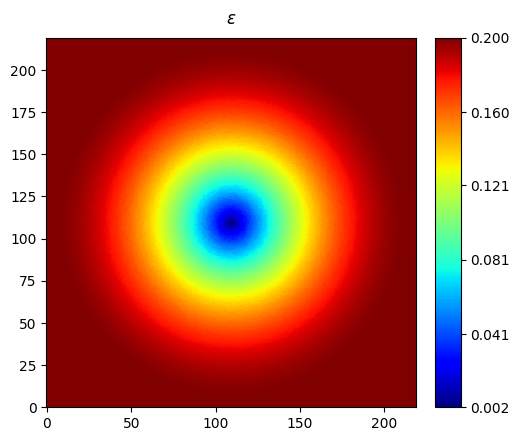

In [ ]:
# Create a mesh
mesh = sl.MeshGenerator(220,254,1)  #220X254

# assign bond properties
sl.mesh.bond_stiffness(mesh, poisson_ratio = 0.2, nondim = True)

# define inelastic strain
exx, eyy, exy = radial_decreasing_powerlaw(mesh.pos[:,0], mesh.pos[:,1], m=2, R=108, ec=0.2)

# assign inelastic strains to the bond network
sl.mesh.plastic_strain(mesh, exx = exx, eyy = eyy, exy = exy)
                          
# plot
sxx, syy, sxy = compute_plastic_strain(mesh)    # inelastic strain

# s = sl.crack.compute_plastic_stress(mesh)     # inelastic stress

x = mesh.pos[:,0]; y= mesh.pos[:,1]
xmin = np.min(x); xmax = np.max(x)
ymin = np.min(y); ymax = np.max(y)

trifield(x, y, sxx, title = r'$\epsilon$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False)
    
    

4. Apply surface forces to the network boundary nodes

In [ ]:
# boundary conditons
_, Tyy, _ = compute_surface_force(mesh, 'bottom')
sl.bcs.load_data_function(mesh, mesh.bottom, fy=-Tyy)

_, Tyy, _ = compute_surface_force(mesh, 'top')
sl.bcs.load_data_function(mesh, mesh.top, fy=Tyy)

Txx, _, _ = compute_surface_force(mesh, 'left')
sl.bcs.load_data_function(mesh, mesh.left, fx=-Txx)

Txx, _, _ = compute_surface_force(mesh, 'right')
sl.bcs.load_data_function(mesh, mesh.right, fx=Txx)

5. Solve

In [ ]:
# solve
sl.solver.static_solve(mesh, endtime = 50000, dt=0.05, zeta = 0.1, vectorfield = 'off',
                interval = 500, folder = 'pl_m1_R108_e05')

<font size = '5'><span style="color:rgba(255, 116, 30, 1);"> Post processing </span></font>

In [21]:
# specify the mplstyle file for the plot
mplstyle_file = r'C:\Users\vinee\OneDrive\Documents\vscode\stressed network model\article_preprint.mplstyle'
plt.style.use(f'{mplstyle_file}')

Load the mesh object from the path directory

In [47]:
folder = r'C:\MyData\Stressed network work\Data\dec_m5_R108_e02_220X254'
mesh = sl.mesh.load_mesh(folder, 'static')

# extract position
x = mesh.pos[:,0]; y= mesh.pos[:,1]
xmin = np.min(x); xmax = np.max(x)
ymin = np.min(y); ymax = np.max(y)

1(a). Extract inelastic strain distribution induced in the network

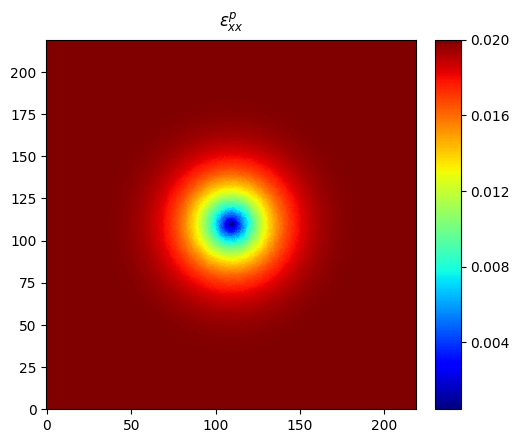

In [ ]:
exx, eyy, exy = compute_plastic_strain(mesh)

# for exx
trifield(x, y, exx, title = r'$\epsilon_{xx}^p$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False, path = folder, filename = 'exxp')

# plot eyy (uncomment if required)
# trifield(x, y, eyy, title = r'$\epsilon_{yy}^p$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#         , save = False, path = folder, filename = 'eyyp')


1(b). Maximum inelastic strain field

max strain: 0.00633449217765817


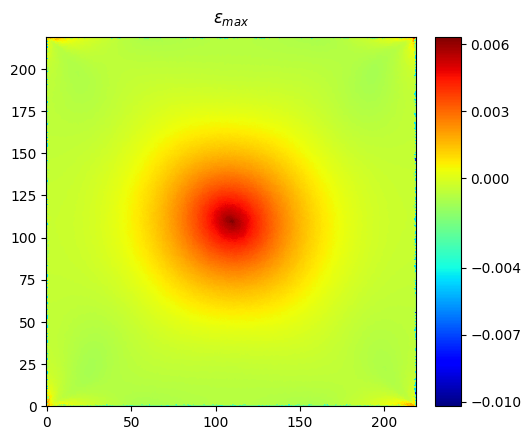

In [18]:
def compute_principal(mesh):
    s = sl.crack.compute_nodal_strain_tensor(mesh)
    total_nodes = mesh.pos.shape[0]

    eig = np.zeros((total_nodes))
    for i in range(total_nodes):
        eig[i] = sl.crack.principal_value(s[i])

    return eig

s = compute_principal(mesh)
print('max strain:', np.max(s))

trifield(x, y, s, title = r'$\epsilon_{max}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False, path = folder, filename = 'emax')

1(c). Maximum strain value along the central horizontal and vertical line

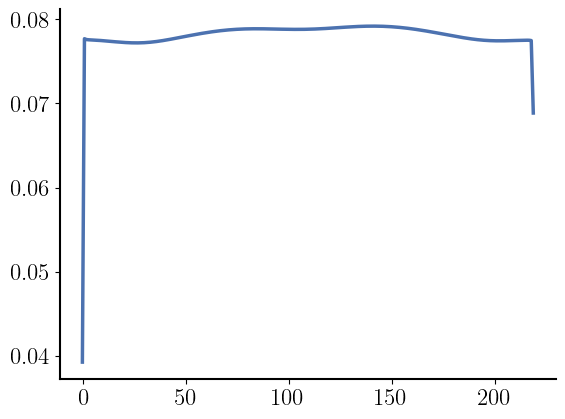

In [22]:
# horizontal line
ids = range(mesh.left[57],mesh.right[57]+1)
x_line = mesh.pos[ids,0]

# central vertical line (uncomment if required)
# lex = lambda i, j, nx: nx*i + j
# j = 50
# ids = [lex(i,j,mesh.nx) for i in range(mesh.ny)]
# x_line = mesh.pos[ids,1]

s_line = s[ids]
fig, ax = plt.subplots()
ax.plot(x_line,s_line)
plt.show()

2(a). Plotting maximum total and residual stress

Max stress: 0.0909246604884674 Min stress: 0.027382648413894917


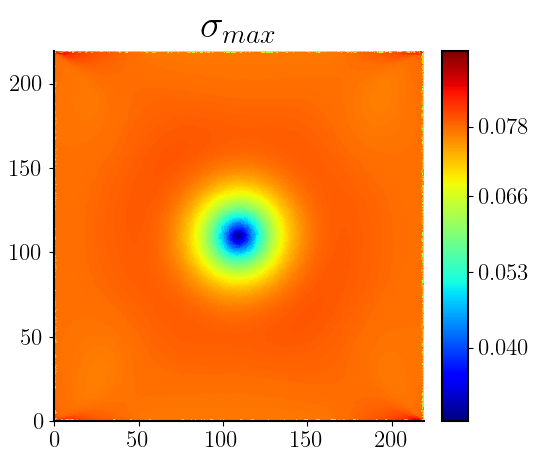

In [ ]:
def compute_principal_stress(mesh):
    stress = sl.crack.compute_nodal_stress_tensor(mesh)
    # Uncomment the following line if you want to compute plastic stress
    # sxx, syy, sxy = sl.solver.compute_plastic_stress(mesh)

    total_nodes = mesh.pos.shape[0]
    eig = np.zeros((total_nodes))
    for i in range(total_nodes):
        # uncomment and substract from stress value to compute residual stress
        # s = np.array([sxx[i], sxy[i], sxy[i], syy[i]])
        eig[i] = sl.crack.principal_value(stress[i])

    return eig 

s = compute_principal_stress(mesh)
print("Max stress:", np.max(s), "Min stress:" , np.min(s))

trifield(x, y, s, title = r'$\sigma_{max}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False, path = folder, filename = 'smax')

2(b). Plot total stress components

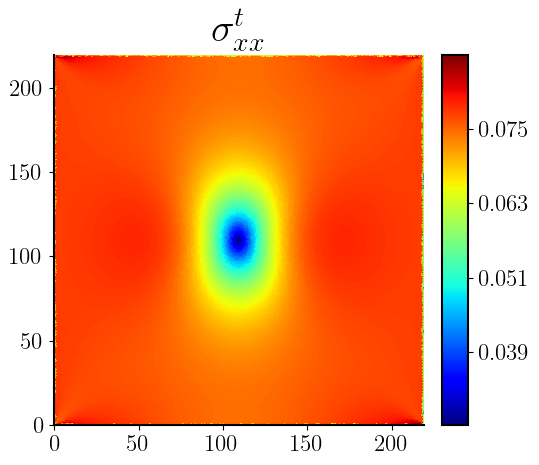

In [ ]:
stress = sl.mesh.compute_nodal_stress_tensor(mesh)

# uncomment and comment others to visualize xy component 
# (Set keyword save=False to visualize but not save to directory)

# trifield(x, y, stress[:,1], title = r'$\sigma_{xy}^t$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = True, path = folder, filename = 'sxyt')

# uncomment and comment others to visualize yy component
# trifield(x, y, stress[:,3], title = r'$\sigma_{yy}^t$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = True, path = folder, filename = 'syyt')

# uncomment and comment others to visualize xx component
trifield(x, y, stress[:,0], title = r'$\sigma_{xx}^t$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False, path = folder, filename = 'sxxt')

2(c). Plot residual stress field

In [ ]:
stress = sl.mesh.compute_nodal_stress_tensor(mesh)
sxx, syy, sxy = sl.solver.compute_plastic_stress(mesh)

# uncomment and comment others to visualize xy component 
# (Set keyword save=False to visualize but not save to directory)
# trifield(x, y, stress[:,1]-sxy, title = r'$\sigma_{xy}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = False, path = folder, filename = 'sxy')

# uncomment and comment others to visualize yy component
# trifield(x, y, stress[:,3]-syy, title = r'$\sigma_{yy}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = False, path = folder, filename = 'syy')

# uncomment and comment others to visualize xx component
# trifield(x, y, stress[:,0]-sxx, title = r'$\sigma_{xx}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = True, path = folder, filename = 'sxx_network', cbarlim = (0, 0.03))

2(d). Plot residual stress in polar coordinates

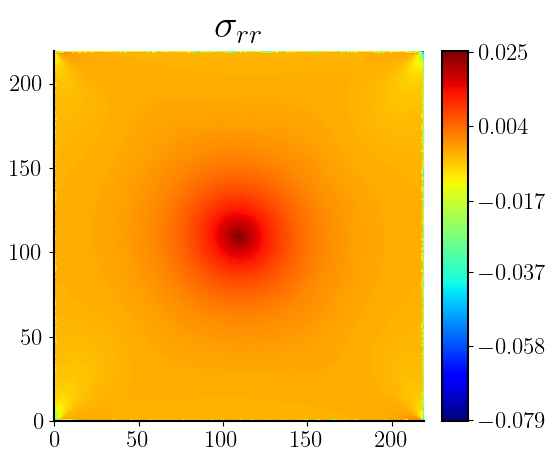

In [32]:
def stress_polar_coords(mesh):
    stress = sl.mesh.compute_nodal_stress_tensor(mesh)
    sxx, syy, sxy = sl.solver.compute_plastic_stress(mesh)

    stress[:,0] = stress[:,0] - sxx; stress[:,3] = stress[:,3] - syy
    stress[:,1] = stress[:,1] - sxy; stress[:,2] = stress[:,2] - sxy
    # center
    xc, yc = np.mean(mesh.pos[:,0]), np.mean(mesh.pos[:,1])
    x = mesh.pos[:,0] - xc; y = mesh.pos[:,1] - yc
    # polar coordinates
    theta = np.arctan2(y,x)

    # stress in polar coordinates
    stress_polar = np.zeros_like(stress)
    for id in range(len(x)):
        q = np.array([[np.cos(theta[id]), np.sin(theta[id])], [-np.sin(theta[id]), np.cos(theta[id])]])
        s = np.array([[stress[id,0], stress[id,1]], [stress[id,2], stress[id,3]]])
        s = np.matmul(q, np.matmul(s, q.T))
        stress_polar[id] = np.array([s[0,0], s[0,1], s[1,0], s[1,1]])

    return stress_polar

stress = stress_polar_coords(mesh)

# uncomment and comment others to visualize rr component
# set keyword save=True to save the figure
trifield(x, y, stress[:,0], title = r'$\sigma_{rr}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
         , save = False, path = folder, filename = 'srr')

# uncomment and comment others to visualize tt component
# trifield(x, y, stress[:,3], title = r'$\sigma_{tt}$', xlim = (xmin, xmax), ylim = (ymin, ymax)
#          , save = True, path = folder, filename = 'stt')


3(a). Extract residual stress along vertical line

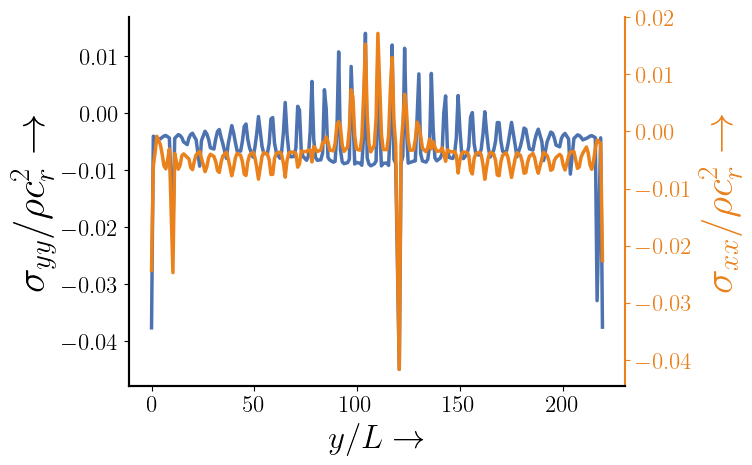

Area syy: -1.2169325745987067
Area sxx: -0.8683663554255454


In [44]:
stress = sl.mesh.compute_nodal_stress_tensor(mesh)
sxx, syy, sxy = sl.solver.compute_plastic_stress(mesh)

lex = lambda i, j, nx: nx*i + j
j = 100
ids = [lex(i,j,mesh.nx) for i in range(mesh.ny)]
x_vertical = mesh.pos[ids,1]
sy = stress[ids,3] - syy[ids]

fig, ax = plt.subplots()
col = ['#4C72B0', '#EB811B', '#14B03D', '#604c38']
ax.plot(x_vertical,sy)  
ax.set_xlabel(r'$y/L\rightarrow$')
ax.set_ylabel(r'$\sigma_{yy}/\rho c_r^2\rightarrow$', fontsize = 30)

sx = stress[ids,0] - sxx[ids]
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color(col[1])
ax.spines['right'].set_linewidth(1.5)
axtwin=ax.twinx()
axtwin.tick_params(axis='y', colors=col[1]) 
axtwin.plot(x_vertical, sx, color = col[1])
axtwin.set_ylabel(r'$\sigma_{xx}/\rho c_r^2\rightarrow$', fontsize = 30)
axtwin.yaxis.label.set_color(col[1])
axtwin.yaxis.label.set_fontweight('bold')
# axtwin.set_yticks(np.round(np.linspace(0,0.7,7),2), fontsize = 24)
# axtwin.set_ylim(0,0.7)
plt.show()
# fig.savefig(folder + f'/resi_profileY.png', bbox_inches = 'tight', dpi = 300)

print('Area syy:', np.trapezoid(sy,x_vertical))
print('Area sxx:', np.trapezoid(sx,x_vertical))


3(a). Extract residual stress along horizontal line

Area syy: -1.0161035898869437
Area sxx: 0.7128714600985462


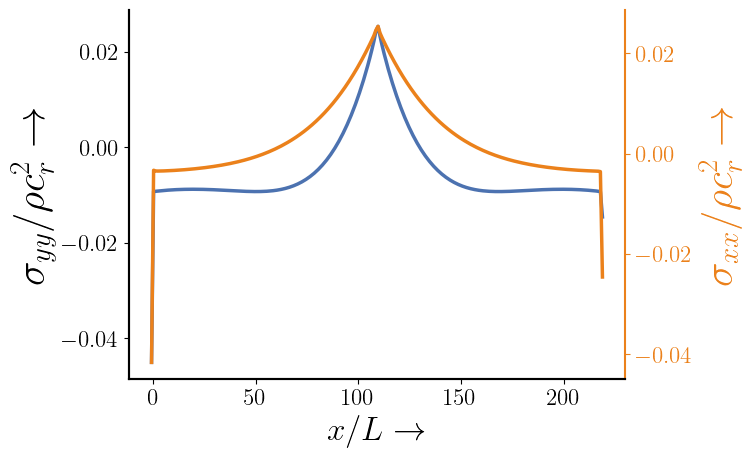

In [49]:
stress = sl.mesh.compute_nodal_stress_tensor(mesh)
sxx, syy, sxy = sl.solver.compute_plastic_stress(mesh)

ids = range(mesh.left[127],mesh.right[127]+1)
x_horizontal = mesh.pos[ids,0]
sy = stress[ids,3] - syy[ids]


fig, ax = plt.subplots()
col = ['#4C72B0', '#EB811B', '#14B03D', '#604c38']
ax.plot(x_horizontal,sy)  
ax.set_xlabel(r'$x/L\rightarrow$')
ax.set_ylabel(r'$\sigma_{yy}/\rho c_r^2\rightarrow$', fontsize = 30)

sx = stress[ids,0] - sxx[ids]

ax.spines['right'].set_visible(True)
ax.spines['right'].set_color(col[1])
ax.spines['right'].set_linewidth(1.5)
axtwin=ax.twinx()
axtwin.tick_params(axis='y', colors=col[1]) 
axtwin.plot(x_horizontal, sx, color = col[1])
axtwin.set_ylabel(r'$\sigma_{xx}/\rho c_r^2\rightarrow$', fontsize = 30)
axtwin.yaxis.label.set_color(col[1])
axtwin.yaxis.label.set_fontweight('bold')
# plt.show()
# fig.savefig(folder + f'/resi_profileX.png', bbox_inches = 'tight', dpi = 300)

print('Area syy:', np.trapezoid(sy,x_horizontal))
print('Area sxx:', np.trapezoid(sx,x_horizontal))

# save data to text files
with open(folder + '/residual_stress_X_network.txt', 'w') as f:
    f.write('x_horizontal sy sx\n')
    for i in range(len(x_horizontal)):
        f.write(f'{x_horizontal[i]} {sy[i]} {sx[i]}\n')


Comparison with FEM solution

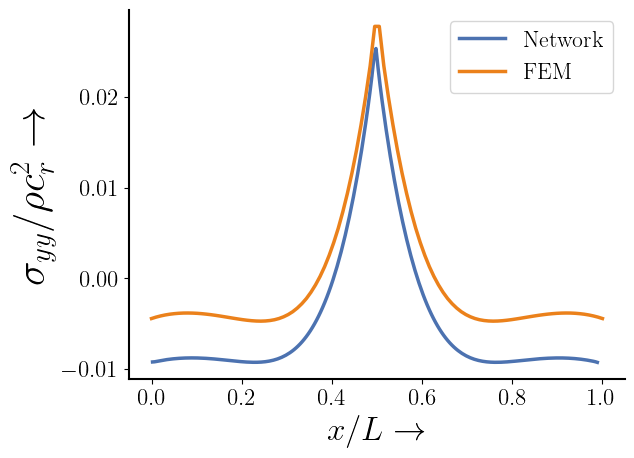

In [63]:
# read network data 
with open(folder + '/residual_stress_X_network.txt', 'r') as f:
    data = f.readlines()[1:]    # skip first line
    x_net, sy_net, sx_net = zip(*[map(float, line.split()) for line in data])

# read FEM data
with open(folder + '/sigma_syy_FEM.txt', 'r') as f:
    data = f.readlines()
    x_fem, sigma_fem = zip(*[map(float, line.split()) for line in data]) 

fig, ax = plt.subplots()
ax.plot(np.array(x_net[1:-1])/220, sy_net[1:-1], label='Network', color=col[0])
ax.plot(x_fem, sigma_fem, label='FEM', color=col[1])
ax.set_xlabel(r'$x/L\rightarrow$')
ax.set_ylabel(r'$\sigma_{yy}/\rho c_r^2\rightarrow$', fontsize = 30)
ax.legend()
plt.show()

fig.savefig(folder + f'/resi_profileX_comparison.png', bbox_inches = 'tight', dpi = 300)